### Loading libs

In [1]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset

from sklearn import cluster, datasets, mixture
# from latentcor import gen_data, get_tps, latentcor

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

In [2]:
from statsmodels.tsa.arima.model import ARIMA

In [3]:
from tqdm import tqdm

In [4]:
import torch
torch.manual_seed(0)

### Reading data

In [5]:
phi = 0.9
sigma = 1
length = 500
len_pred = 50
coef = torch.rand((length))
off = torch.randn((length))
num_samples = 500

cov = np.zeros((length, length))
row = np.cumprod([1] + [phi]*(length-1))
for i in range(length):
    cov[i, :(i+1)] = np.flip(row[:(i+1)])
    cov[i, (i+1):] = row[1:(length-i)]
cov = (cov / (1 - phi**2)).astype(np.float32)
cov = torch.tensor(cov)
cov_chol = torch.linalg.cholesky(cov, upper=True)
true_cov = cov * (sigma**2)

def data_gen(n_samples, length, len_pred, true_cov_chol, sigma, coef, off):
    while 1:
        x = torch.randn((n_samples, length)) * sigma
        x = torch.matmul(x, true_cov_chol)
        xy_latent = torch.clone(x)
        for i in range(n_samples):
            x[i, :] = torch.exp(torch.tanh(x[i, :] * coef)) + off
        yield x[:, :-len_pred], x[:, -len_pred:], xy_latent

In [6]:
data_gen_init = data_gen(num_samples, length, len_pred, cov_chol, sigma, coef, off)

In [7]:
for (x, y, _) in data_gen_init: break

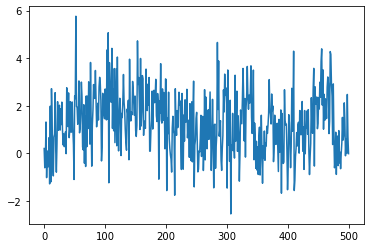

In [8]:
plt.plot(np.concatenate([x[0, :].numpy(), y[0, :].numpy()]))

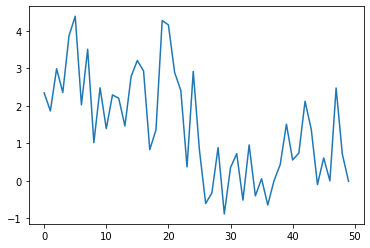

In [9]:
plt.plot(y[0, :].numpy())

In [10]:
coef[0:10]

tensor([0.4963, 0.7682, 0.0885, 0.1320, 0.3074, 0.6341, 0.4901, 0.8964, 0.4556,
        0.6323])

In [11]:
off[0:10]

tensor([-0.1642, -0.9715, -1.0308,  0.6473, -1.4583, -0.2817, -1.0300, -0.6884,
         0.2194, -1.6989])

### Define model

In [12]:
class RealNVP(nn.Module):
    def __init__(self, nets1, nett1, mask1, 
                 nets2, nett2, mask2, prior1, prior2, pred_mat, cov_cond, pred_len):
        super(RealNVP, self).__init__()
        
        self.pred_len = pred_len
        self.pred_mat = nn.Parameter(data=pred_mat, requires_grad=False)
        self.cov_cond = nn.Parameter(data=cov_cond, requires_grad=False)
        
        self.prior1 = prior1
        self.prior2 = prior2
        
        self.mask1 = nn.Parameter(mask1, requires_grad=False)
        self.t1 = torch.nn.ModuleList([nett1() for _ in range(len(mask1))])
        self.s1 = torch.nn.ModuleList([nets1() for _ in range(len(mask1))])
        
        self.mask2 = nn.Parameter(mask2, requires_grad=False)
        self.t2 = torch.nn.ModuleList([nett2() for _ in range(len(mask2))])
        self.s2 = torch.nn.ModuleList([nets2() for _ in range(len(mask2))])
        
    def g(self, x1, x2):
        # send to latent and predict (with Gaussian)
        z1, z2, _ = self.f(x1, x2)
        z2 = torch.matmul(self.pred_mat, z1.permute(1, 0)).permute(1, 0)
        
        z2_upper = z2 + 1.96 * torch.diag(self.cov_cond)
        z2_lower = z2 - 1.96 * torch.diag(self.cov_cond)
        z2 = torch.cat([z2, z2_upper, z2_lower], 0)
        
        x1_inv, x2 = torch.clone(z1), torch.clone(z2)
        x1 = torch.cat([x1]*3, 0)
        
        for i in range(len(self.t1)):
            x1_ = x1_inv * self.mask1[i]
            s1 = self.s1[i](x1_)
            t1 = self.t1[i](x1_)
            x1_inv = x1_ + (1 - self.mask1[i]) * (x1_inv * torch.exp(s1) + t1)
            
        for i in range(len(self.t1)):
            x2_ = x2 * self.mask2[i]
            x2cond_ = torch.cat([x2_, x1], 1)
            s2 = self.s2[i](x2cond_)
            t2 = self.t2[i](x2cond_)
            x2 = x2_ + (1 - self.mask2[i]) * (x2 * torch.exp(s2) + t2)
            
        return z1, z2, z2_upper, z2_lower, x1_inv, x2

    def f(self, x1, x2):
        log_det_J1, z1 = x1.new_zeros(x1.shape[0]), x1
        for i in reversed(range(len(self.t1))):
            z1_ = self.mask1[i] * z1
            s1 = self.s1[i](z1_)
            t1 = self.t1[i](z1_)
            z1 = (1 - self.mask1[i]) * ((z1 - t1) * torch.exp(-s1)) + z1_
            log_det_J1 -= s1.sum(dim=1)
        
        log_det_J2, z2 = x2.new_zeros(x2.shape[0]), x2
        for i in reversed(range(len(self.t1))):
            z2_ = self.mask2[i] * z2
            z2cond_ = torch.cat([z2_, x1], 1)
            s2 = self.s2[i](z2cond_)
            t2 = self.t2[i](z2cond_)
            z2 = (1 - self.mask2[i]) * ((z2 - t2) * torch.exp(-s2)) + z2_
            log_det_J2 -= s2.sum(dim=1)
        
        return z1, z2, log_det_J1+log_det_J2
    
    def log_prob(self,x1,x2):
        z1, z2, logp = self.f(x1, x2)
        return self.prior1.log_prob(z1) + self.prior2.log_prob(z2) + logp

In [13]:
n = 500
pred_len = 50

nets1 = lambda: nn.Sequential(nn.Linear(450, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 450), 
                             nn.Tanh())
nett1 = lambda: nn.Sequential(nn.Linear(450, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 450))

nets2 = lambda: nn.Sequential(nn.Linear(500, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 50), 
                             nn.Tanh())
nett2 = lambda: nn.Sequential(nn.Linear(500, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 50))

mask1_x = [0]*((n - pred_len) // 2) + [1]*((n - pred_len) // 2)
mask2_x = [1]*((n - pred_len) // 2) + [0]*((n - pred_len) // 2)
mask1_y = [0]*(pred_len // 2) + [1]*(pred_len // 2)
mask2_y = [1]*(pred_len // 2) + [0]*(pred_len // 2)
masks_x = torch.from_numpy(np.array([mask1_x, mask2_x] * 10).astype(np.float32))
masks_y = torch.from_numpy(np.array([mask1_y, mask2_y] * 10).astype(np.float32))

pred_mat = torch.matmul(true_cov[-pred_len:, :-pred_len], true_cov[:-pred_len, :-pred_len].inverse())
cov_cond = true_cov[-pred_len:, -pred_len:] - torch.matmul(pred_mat, true_cov[:-pred_len, -pred_len:])
# prior1 = distributions.MultivariateNormal(torch.zeros(n-pred_len).cuda(), 
#                                           true_cov[:(n-pred_len), :(n-pred_len)].cuda())
# prior2 = distributions.MultivariateNormal(torch.zeros(pred_len).cuda(), cov_cond.cuda())
prior1 = distributions.MultivariateNormal(torch.zeros(n-pred_len), 
                                          true_cov[:(n-pred_len), :(n-pred_len)])
prior2 = distributions.MultivariateNormal(torch.zeros(pred_len), cov_cond)

flow = RealNVP(nets1, nett1, masks_x, nets2, nett2, masks_y, prior1, prior2, pred_mat, cov_cond, pred_len)
# flow.to('cuda')

In [ ]:
EPOCHS = 100

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for epoch in range(EPOCHS):
    train_loss = []
    epoch_time = time.time()
    curr_time = time.time()
    
    for i, (x1, x2, _) in enumerate(data_gen_init):
        if i > 100:
            break
        x1, x2 = x1.cuda(), x2.cuda()
        loss = -flow.log_prob(x1, x2).mean()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        train_loss.append(loss.item())
        if (i+1) % 10 == 0:
            print('\titers: {0}, epoch: {1} | loss: {2:.3f}'.format((i+1), epoch + 1, loss.item()))
            speed = (time.time() - curr_time) / (i+1)
            left_time = speed * ((EPOCHS - epoch) * 100 - (i+1))
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
    
    # compute average train loss
    train_loss = np.average(train_loss)
    print("epoch: {}, epoch time: {}, loss: {}".format(epoch+1, time.time() - curr_time, train_loss))

In [ ]:
torch.save(flow.state_dict(), './model.pt')
torch.save(optimizer.state_dict(), './optim.pt')

In [14]:
flow.load_state_dict(torch.load('./model.pt'), strict=False)

_IncompatibleKeys(missing_keys=['cov_cond'], unexpected_keys=[])

In [15]:
torch.manual_seed(1)
for (x, y, xy_truelatent) in data_gen_init:
#     x, y = x.cuda(), y.cuda()
    break
# y_test = torch.zeros_like(y).cuda()
y_test = torch.zeros_like(y)

In [16]:
# flow.to('cpu')
flow.eval()

# predict
x_latent, y_latent, y_latent_upper, y_latent_lower, x_pred, y_pred = flow.g(x, y_test)

In [17]:
y_latent_lower.shape

torch.Size([500, 50])

In [18]:
x_pred, y_pred = x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()
x_latent, y_latent = x_latent.detach().cpu().numpy(), y_latent.detach().cpu().numpy()
y_latent_upper, y_latent_lower = y_latent_upper.detach().cpu().numpy(), y_latent_lower.detach().cpu().numpy()

x_truelatent = xy_truelatent[:-len_pred].cpu().numpy()
y_truelatent = xy_truelatent[-len_pred:].cpu().numpy()
x = x.cpu().numpy()
y = y.cpu().numpy()

### Plot true latent vs. pred latent mean

In [31]:
y_truelatentmean = torch.matmul(pred_mat, xy_truelatent[:, :-pred_len].permute(1, 0)).permute(1, 0)

In [36]:
y_truelatentmean = y_truelatentmean.numpy()

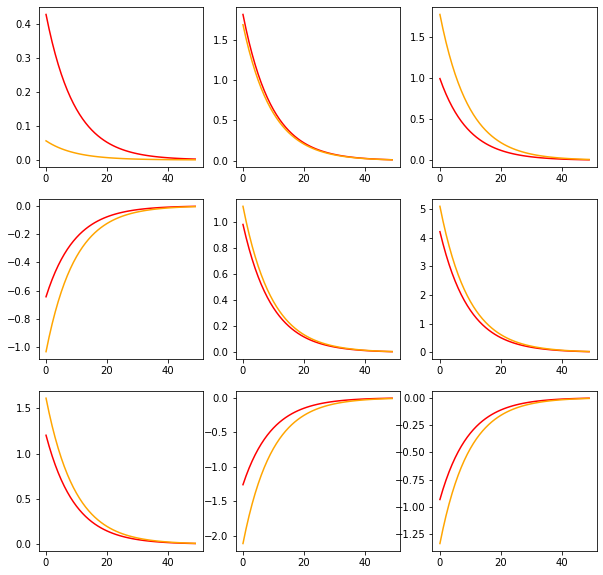

In [39]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.reshape(-1)):
    ax.plot(y_latent[i, :], color='red')
    ax.plot(y_truelatentmean[i, :], color='orange')

### Plot CI

In [20]:
torch.diag(cov_cond)

tensor([1.0000, 1.8100, 2.4661, 2.9975, 3.4280, 3.7767, 4.0591, 4.2879, 4.4732,
        4.6233, 4.7449, 4.8433, 4.9231, 4.9877, 5.0400, 5.0824, 5.1168, 5.1446,
        5.1671, 5.1854, 5.2001, 5.2121, 5.2218, 5.2297, 5.2360, 5.2412, 5.2454,
        5.2487, 5.2515, 5.2537, 5.2555, 5.2570, 5.2581, 5.2591, 5.2599, 5.2605,
        5.2610, 5.2614, 5.2617, 5.2620, 5.2622, 5.2624, 5.2625, 5.2627, 5.2628,
        5.2628, 5.2629, 5.2629, 5.2630, 5.2630])

In [21]:
y_pred[500, ]

array([2.5773642 , 1.9656711 , 3.0518844 , 2.4597166 , 5.315164  ,
       4.954811  , 2.5149715 , 4.120788  , 3.0345323 , 2.8415182 ,
       1.5013075 , 2.8150659 , 2.371577  , 2.9384017 , 3.2080414 ,
       3.7527447 , 4.3092165 , 1.8621103 , 2.5166125 , 5.4390526 ,
       4.613247  , 3.2919345 , 3.0089931 , 2.1597195 , 5.1045666 ,
       0.97982347, 0.53235936, 2.2919302 , 3.251336  , 1.6480638 ,
       2.5385618 , 3.310286  , 1.1912292 , 3.7300344 , 2.6704524 ,
       2.6643386 , 1.9939127 , 2.721577  , 2.8929176 , 4.087103  ,
       2.4328272 , 3.1688795 , 3.8287406 , 3.4694552 , 2.242319  ,
       2.611041  , 0.641588  , 2.616025  , 2.751443  , 2.229433  ],
      dtype=float32)

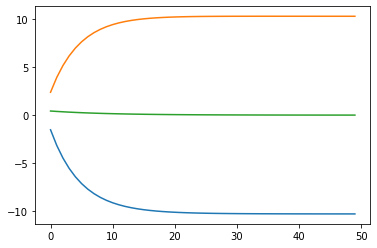

In [22]:
plt.plot(y_latent_lower[0, ])
plt.plot(y_latent_upper[0, ])
plt.plot(y_latent[0, ])

In [23]:
y_pred[550, ]

array([2.4703457 , 1.9510622 , 3.0758286 , 2.474861  , 4.6362906 ,
       5.0203757 , 2.680793  , 4.1440053 , 2.6491046 , 2.724017  ,
       1.4859898 , 2.755109  , 2.3891387 , 2.9458065 , 3.1817079 ,
       3.6151974 , 4.2232704 , 2.0198982 , 2.6506503 , 5.4880877 ,
       4.626645  , 3.259863  , 3.0074956 , 2.1104984 , 5.132884  ,
       0.9768269 , 0.57148117, 2.316981  , 3.2870023 , 1.6874187 ,
       2.637216  , 3.4919894 , 1.301504  , 3.695871  , 2.7198899 ,
       2.662996  , 1.9949603 , 2.7022157 , 2.9515374 , 4.1959944 ,
       2.4363632 , 3.4443452 , 3.7654834 , 3.3705852 , 2.245229  ,
       2.6935403 , 0.75914997, 2.8773637 , 2.5925984 , 2.227275  ],
      dtype=float32)

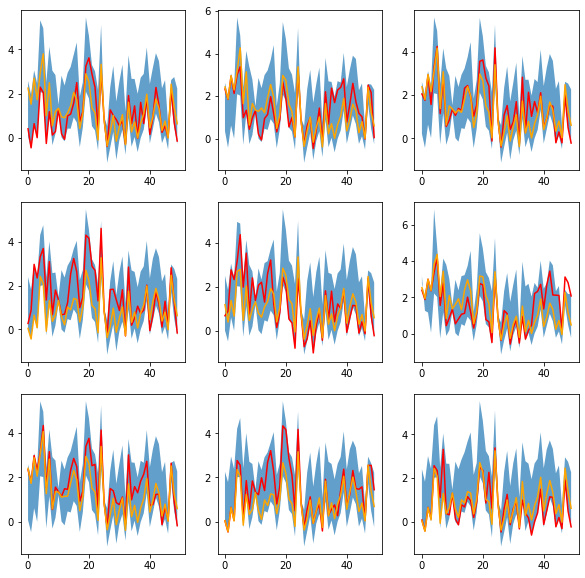

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.reshape(-1)):
    ax.plot(y[i, :], color='red')
    ax.plot(y_pred[i, :], color='orange')
    ax.fill_between(range(50, ), y_pred[1000+i, :], y_pred[500+i, :], alpha=0.7)

### ARIMA model

In [19]:
yhat_mat = np.empty((num_samples, pred_len))
for i in tqdm(range(num_samples)):
    history = list(x[i, :])
    obs = list(y[i, :])
    predictions = list()
    # walk-forward validation
    for t in range(len_pred):
        model = ARIMA(history, order=(1,0,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(obs[t])
    yhat_mat[i, :] = predictions

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [12:27<00:00,  1.49s/it]


### Test:: APE and RMSE

In [20]:
np.median(((y_pred[:num_samples, :] - y)**2).mean(axis=1))

0.5131813

In [21]:
np.median(((yhat_mat - y)**2).mean(axis=1))

1.1360627633356648

In [22]:
np.median(np.abs((y_pred[:num_samples, :] - y) / y).mean(axis=1))

1.1893215

In [23]:
np.median(np.abs((yhat_mat - y) / y).mean(axis=1))

3.412909944810847

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
ind = np.array(range(25)).reshape((5, 5))
for i in range(5):
    for j in range(5):
        axs[i, j].plot(y[ind[i, j]+10, :])
        axs[i, j].plot(y_pred[ind[i,j]+10, :])

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(15,15))
for i in range(5):
    if i == 0:
        axs[i, 0].set_title('True y')
        axs[i, 1].set_title('Predicted y')
        axs[i, 2].set_title('Predicted latent z_2')
        axs[i, 3].set_title('True latent z_2')
    axs[i, 0].plot(y[i+10, :])
    axs[i, 1].plot(y_pred[i+10, :])
    axs[i, 2].plot(y_latent[i+10, :])
    axs[i, 3].plot(y_truelatent[i+10, :])

### Previous trials

In [ ]:
# # predict last 24

# test_data


# for index in range(data_test.shape[0]):
#     # pad with mean
#     sample = np.concatenate((data_test[index, :-24], [np.mean(data_test[index, :-24])]*24))[np.newaxis, :]
#     # iterate prediction step until convergence
#     print('Index: {0}'.format(index))
#     for i in range(5):
#         z, logp = flow.f(torch.from_numpy(sample))
#         print('\tlog prob: {0:.4f}'.format(logp.item()))
#         z = z.detach().numpy()[0]
#         zhat = cov[-24:, :-24] @ np.linalg.inv(cov[:-24, :-24]) @ z[:-24]
#         z = np.concatenate((z[:-24], zhat))
#         sample = flow.g(torch.from_numpy(z[np.newaxis, :])).detach().numpy()
#     # compute confidence band
#     z_upper = np.concatenate((z[:-24], zhat + 2*np.sqrt(np.diag(pred_cov))))
#     z_lower = np.concatenate((z[:-24], zhat - 2*np.sqrt(np.diag(pred_cov))))
#     sample_upper = flow.g(torch.from_numpy(z_lower[np.newaxis, :])).detach().numpy()
#     sample_lower = flow.g(torch.from_numpy(z_upper[np.newaxis, :])).detach().numpy()
#     # save results
#     pred[index, :] = sample[0, :]; pred_lower[index, :] = sample_lower[0, :]; pred_upper[index, :] = sample_upper[0, :]

In [ ]:
# true = scaler.inverse_transform(data_test)[:, -24:]
# pred = scaler.inverse_transform(pred)[:, -24:]
# pred_lower = scaler.inverse_transform(pred_lower)[:, -24:]
# pred_upper = scaler.inverse_transform(pred_upper)[:, -24:]
# print(np.mean((true - pred)**2))

In [ ]:
# index = 1
# plt.plot(true[index, :], color='red')
# plt.plot(pred[index, :], color='blue')
# plt.plot(pred_lower[index, :], color='blue')
# plt.plot(pred_upper[index, :], color='blue')

In [ ]:
# plt.hist(np.mean((true-pred)**2, axis = 1))